In [1]:
%matplotlib inline

import urllib2
import os
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity

figsize(10,8)
plt.xkcd();

## Load Data to Memory

Load data output from *marathon_data_munging.ipynb* IPython Notebook.

In [2]:
nyc_data = pd.read_pickle("./nyc_marathon_2015_processed.pickle")
nyc_data.head()

,name,state,country,age,gender,26.2_mi,5_km,10_km,15_km,20_km,13.1_mi,25_km,30_km,35_km
0,guyula chris,ac,aus,19,m,4.603889,0.432500,0.894167,1.354167,1.896667,2.020000,2.474444,3.045000,3.732500
1,forte benjamin,in,usa,18,m,5.676944,0.628889,1.254444,1.874722,2.513889,2.674444,3.220833,3.921389,4.618611
2,birzin david,nj,usa,18,m,4.155833,0.447778,0.885000,1.317778,1.754444,1.856111,2.228333,2.712778,3.314722
3,bolona leopold,nj,usa,18,m,6.022222,0.616667,1.235278,1.877222,2.605000,2.763333,3.362778,4.212500,5.009167
4,tortora salvatore,ny,usa,19,m,4.041111,0.455278,0.885556,1.337778,1.814722,1.926111,2.325556,2.802778,3.298333


In [3]:
lon_data = pd.read_pickle("./london_marathon_2015_processed.pickle")
lon_data.head()

,name,country,age_cat,13.1_mi,26.2_mi
0,aarons elaine,gbr,45-49,2.411389,4.978333
1,aarons ian daniel,gbr,18-39,NaN,NaN
2,abbar hani,gbr,18-39,2.373333,4.835556
3,abbas charlotte,gbr,18-39,3.230278,6.846667
4,abbasnejad pegah,gbr,18-39,2.161389,4.478611


## Analysis

Calculate 0.05 increment quantiles for both the London and NYC Marathon finish times. Plot these against each other to see how a time in the NYC Marathon translates to London.

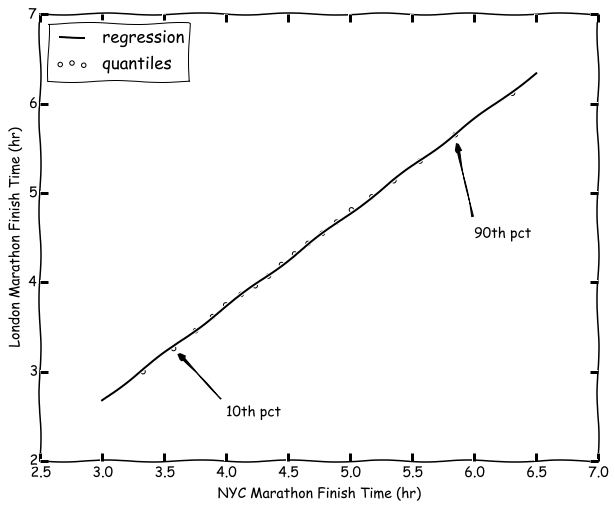

In [5]:
q = np.linspace(0, 1, 21)[1:-1]

nyc_qtimes = nyc_data["26.2_mi"].quantile(q)
lon_qtimes = lon_data["26.2_mi"].quantile(q)

# Plot raw data
plt.scatter(nyc_qtimes, lon_qtimes, facecolor="none", label="quantiles", color="k")
plt.xlabel("NYC Marathon Finish Time (hr)")
plt.ylabel("London Marathon Finish Time (hr)")

# Linear Regression
lin_re = LinearRegression(fit_intercept=True)
lin_re.fit(nyc_qtimes[:, np.newaxis], lon_qtimes[:, np.newaxis])
lin_re_x = np.linspace(3, 6.5, 100)[:, np.newaxis]
plt.plot(lin_re_x, lin_re.predict(lin_re_x), label="regression", color="k")
plt.legend(loc="best");

# 10th percentile
plt.annotate('10th pct', 
             xy=(nyc_qtimes[0.1], lon_qtimes[0.1]), xytext=(4, 2.5), 
             arrowprops=dict(facecolor="k", shrink=0.1, width=1, headwidth=5)
            )

# 90th percentile
plt.annotate('90th pct', 
             xy=(nyc_qtimes[0.9], lon_qtimes[0.9]), xytext=(6.0, 4.5), 
             arrowprops=dict(facecolor="k", shrink=0.1, width=1, headwidth=5)
            );

In [6]:
print ("Regression is: lon_time = {0:5.2f} + {1:4.2f} x nyc_time".format(lin_re.intercept_[0], lin_re.coef_[0][0]))

Regression is: lon_time = -0.46 + 1.05 x nyc_time


Caroline Wozniacki's 2014 NYC Marathon time was 3:26:33, or 3.4425 hours. Based on the regression, this roughly equates to a London Marathon time of 03:08:17.

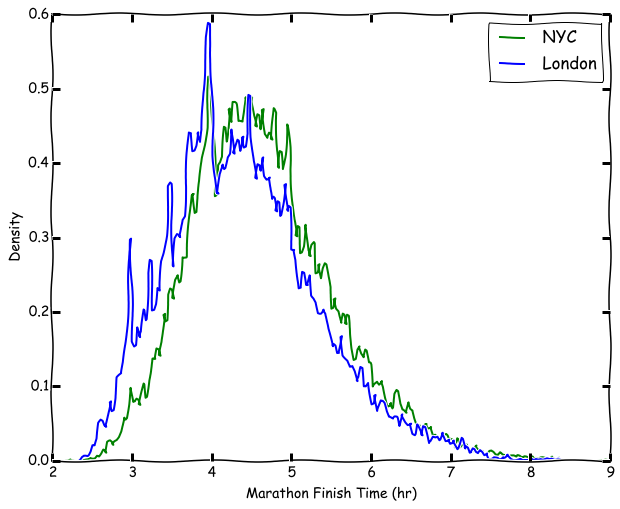

In [7]:
def kde_plot(kde_train_data, range_min, range_max, eval_pts=250, kernel="gaussian", bandwidth=1):
    """
    Outputs kde-ified data for plotting. Use as a replacement for hist. The inputs
    range_min and range_max correspond to the min and max of the data range of interest, 
    respectively.
    """
    kde_train_data = kde_train_data.dropna()[:, np.newaxis]
    kde_eval_x = np.linspace(range_min, range_max, eval_pts)[:, np.newaxis]
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde.fit(kde_train_data)
    kde_eval_y = np.exp(kde.score_samples(kde_eval_x))
    
    return (kde_eval_x, kde_eval_y)


nyc_x, nyc_y = kde_plot(nyc_data["26.2_mi"], range_min=2, range_max=9, bandwidth=0.01)
lon_x, lon_y = kde_plot(lon_data["26.2_mi"], range_min=2, range_max=9, bandwidth=0.01)
plt.plot(nyc_x, nyc_y, "-", color="g", label="NYC")
plt.plot(lon_x, lon_y, "-", color="b", label="London")
plt.legend(loc="best")
plt.xlabel("Marathon Finish Time (hr)")
plt.ylabel("Density");

In plot above, the spike right before the three and four hour marks is... interesting. Analysis part of this is perfect for something like Tableau or Periscope since there are many ways to slice the data. 

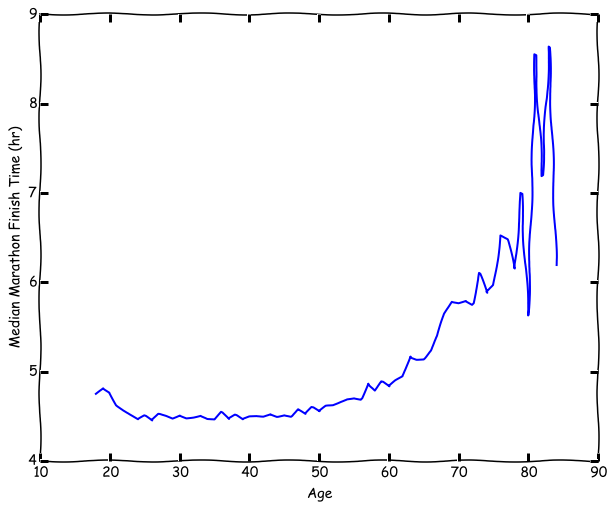

In [8]:
finish_by_age = nyc_data.groupby("age")["26.2_mi"].median()
plt.plot(finish_by_age.keys(), finish_by_age.values)
plt.xlabel("Age")
plt.ylabel("Median Marathon Finish Time (hr)");